# Normalization scheme for initialization of tensorized neural networks


In this notebook we will exemplify the initialization method of tensorized neural networks using the partial Frobenius norm method and the partial lineal entrywise norm method with the case of Tensor Train and Tensor Train Matrix layers.

We create a generic class for a tensor network layer that contains this method. Once created, we will create classes that inherit from it, in which we have defined both the calculation of the norms and the partial norms.

We will use only the following libraries:

- tensorkrowch and torch, for the layer definitions.

- Numpy, for other functions.

Paper reference:

This work is based on the paper "Efficient Finite Initialization for Tensorized Neural Networks"

Published in arXiv (2024)

Authors: Alejandro Mata Ali, Iñigo Perez Delgado, Marina Ristol Roura, Aitor Moreno Fdez. de Leceta

Paper: https://arxiv.org/abs/2309.06577

Citation:
``@misc{ali2024efficientfiniteinitializationtensorized,
    title={Efficient Finite Initialization for Tensorized Neural Networks},
    author={Mata Ali, Alejandro and Perez Delgado, Iñigo and Ristol Roura, Marina and Moreno Fdez. de Leceta, Aitor},
    year={2024},
    eprint={2309.06577},
    archivePrefix={arXiv},
    primaryClass={cs.LG},
    url={https://arxiv.org/abs/2309.06577}
}``

In [11]:
import tensorkrowch as tk
import torch
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams


---
# Tensor Network Layer

The following classes implement different types of tensor networks:

TN (Tensor Network): Base class that provides common functionality for tensor network layers, including initialization and normalization methods.

MPO (Matrix Product Operator): A specialized tensor network structure where tensors are arranged in a 1D chain, with each tensor having 4 indices - 2 physical and 2 virtual bond indices. Commonly used to represent quantum operators.

MPS (Matrix Product State): Similar to MPO but with 3 indices per tensor - 1 physical and 2 virtual bond indices. Efficiently represents quantum many-body wavefunctions in 1D systems.




## Superclass general TN

In [12]:
class TN_general:
    '''Base class for tensor network layers.'''
    def __init__(self,
                n_nodes:int,
                name:str='Layer_Auto',
                max_tol:float=1e20,
                min_tol:float=1e-20,
                norm_factor:float=1):
        """Initialize tensor network layer.
        
        Args:
            num_nodes: Number of nodes in the network
            name: Name of the layer
            max_tolerance: Maximum tolerance for normalization
            min_tolerance: Minimum tolerance for normalization 
            normalization_factor: Normalization factor
        """
        self.n_nodes = n_nodes
        self.norm_factor = norm_factor
        self.max_tol = max_tol
        self.min_tol = min_tol

    def normalize(self,
                max_iterations:int=100,
                method:str='Frobenius'):
        """Normalize the tensor network initialization.
        
        Args:
            max_iterations: Maximum number of iterations allowed
            method: Normalization method ('Frobenius' or 'Linear')
            verbose: Whether to track number of steps
        """
        # Calculate initial norm
        if method == 'Frobenius':
            norm = self.compute_frob()
            exponent = 1/(2*self.n_nodes)
        elif method == 'Lineal':
            norm = self.compute_lineal() 
            exponent = 1/self.n_nodes

        norm /= self.norm_factor

        # Classify initial norm
        if np.isnan(norm):
            norm_state = 1  # nan
        elif self.min_tol < norm < self.max_tol:
            norm_state = 0  # in range
        elif norm == np.inf:
            norm_state = 1  # inf
        elif norm > self.max_tol:
            norm_state = 2  # greater
        elif norm == 0:
            norm_state = -1  # zero
        else:
            norm_state = -2  # lower

        # Initial normalization if finite
        if norm_state in (2, -2, 0):
            for node_idx in range(self.n_nodes):
                self.layer_nodes[node_idx].tensor = self.layer_nodes[node_idx].tensor/(norm**exponent)
            norm_state = 0

        # Iterative normalization if needed
        if norm_state != 0:
            normalize_node0 = True
            self.steps = 1
        else:
            normalize_node0 = False
            self.steps = 0

        # Node 0 normalization
        while normalize_node0 and self.steps < max_iterations:
            partial_norm = self.compute_part_frob(0)
            partial_norm /= self.norm_factor

            if norm_state == 1 and partial_norm > self.max_tol:  # Infinite case
                if partial_norm == np.inf or np.isnan(partial_norm):
                    scaling_factor = (10*(1+np.random.rand()))**exponent
                    for node_idx in range(self.n_nodes):
                        self.layer_nodes[node_idx].tensor = self.layer_nodes[node_idx].tensor/scaling_factor
                    self.steps += 1
                else:  # Finite case
                    scaling_factor = partial_norm**exponent
                    for node_idx in range(self.n_nodes):
                        self.layer_nodes[node_idx].tensor = self.layer_nodes[node_idx].tensor/scaling_factor
                    partial_norm /= scaling_factor
                    normalize_node0 = False

            elif norm_state == -1 and partial_norm < self.min_tol:  # Zero case
                if partial_norm == 0:
                    scaling_factor = (0.1/(1+np.random.rand()))**exponent
                    for node_idx in range(self.n_nodes):
                        self.layer_nodes[node_idx].tensor = self.layer_nodes[node_idx].tensor/scaling_factor
                    self.steps += 1
                else:  # Finite case
                    scaling_factor = partial_norm**exponent
                    for node_idx in range(self.n_nodes):
                        self.layer_nodes[node_idx].tensor = self.layer_nodes[node_idx].tensor/scaling_factor
                    partial_norm /= scaling_factor
                    normalize_node0 = False
            else:  # In range
                normalize_node0 = False

        # Check norm after node 0
        norm, norm_state = self.classificate_norm(method)

        if norm_state in (2, -2, 0):
            scaling_factor = norm**exponent
            for node_idx in range(self.n_nodes):
                self.layer_nodes[node_idx].tensor = self.layer_nodes[node_idx].tensor/scaling_factor
            norm_state = 0

        # Normalize remaining nodes
        start_node = 1
        continue_normalizing = True
        while norm_state != 0 and self.steps <= max_iterations:
            normalize_final = True
            for node_idx in range(start_node, self.n_nodes-1):
                prev_norm = partial_norm
                if method == 'Frobenius':
                    partial_norm = self.compute_part_frob(node_idx)
                elif method == 'Lineal':
                    partial_norm = self.compute_part_lineal(node_idx)

                partial_norm /= self.norm_factor

                if norm_state == 1 and partial_norm > self.max_tol:  # Infinity case
                    normalize_final = False
                    if partial_norm == np.inf or np.isnan(partial_norm):
                        start_node = node_idx
                        partial_norm = prev_norm
                        scaling_factor = partial_norm**exponent
                        for j in range(self.n_nodes):
                            self.layer_nodes[j].tensor = self.layer_nodes[j].tensor/scaling_factor
                        partial_norm /= scaling_factor**(node_idx)
                        self.steps += 1
                        continue_normalizing = False
                        break
                    else:
                        scaling_factor = partial_norm**exponent
                        for j in range(self.n_nodes):
                            self.layer_nodes[j].tensor = self.layer_nodes[j].tensor/scaling_factor

                elif norm_state == -1 and partial_norm < self.min_tol:  # Zero case
                    normalize_final = False
                    if partial_norm == 0:
                        start_node = node_idx
                        partial_norm = prev_norm
                        scaling_factor = partial_norm**exponent
                        for j in range(self.n_nodes):
                            self.layer_nodes[j].tensor = self.layer_nodes[j].tensor/scaling_factor
                        partial_norm /= scaling_factor**(node_idx)
                        self.steps += 1
                        continue_normalizing = False
                        break
                    else:
                        scaling_factor = partial_norm**exponent
                        for j in range(self.n_nodes):
                            self.layer_nodes[j].tensor = self.layer_nodes[j].tensor/scaling_factor
                else:
                    pass

            # Final node normalization
            if normalize_final:
                final_node = self.n_nodes-2
                scaling_factor = partial_norm**exponent
                for j in range(self.n_nodes):
                    self.layer_nodes[j].tensor = self.layer_nodes[j].tensor/scaling_factor
                partial_norm /= scaling_factor**(final_node+1)

            # Check final norm
            norm, norm_state = self.classificate_norm(method)

            if norm_state in (2, -2, 0):
                scaling_factor = norm**exponent
                for j in range(self.n_nodes):
                    self.layer_nodes[j].tensor = self.layer_nodes[j].tensor/scaling_factor
                norm, norm_state = self.classificate_norm(method)
                if norm_state != 0 and continue_normalizing:
                    self.steps += 1
            elif continue_normalizing:
                self.steps += 1

    def classificate_norm(self,
                        method:str='Frobenius'):
        """Classify the norm of the tensor network.
        
        Args:
            method: Normalization method
            
        Returns:
            norm: Calculated norm value
            norm_state: Classification of the norm (-2: lower, -1: zero, 0: in range, 
                   1: inf/nan, 2: greater)
        """
        if method == 'Frobenius':
            norm = self.compute_frob()
        elif method == 'Lineal':
            norm = self.compute_lineal()
                
        norm /= self.norm_factor

        if np.isnan(norm):
            norm_state = 1  # nan
        elif self.min_tol < norm < self.max_tol:
            norm_state = 0  # in range
        elif norm == np.inf:
            norm_state = 1  # inf
        elif norm > self.max_tol:
            norm_state = 2  # greater
        elif norm == 0:
            norm_state = -1  # zero
        else:
            norm_state = -2  # lower

        return norm, norm_state


## MPO class

In [13]:
class MPO(TN_general):
    """Matrix Product Operator (MPO) class that inherits from TN_general.
    
    An MPO represents a quantum operator as a tensor network of rank-4 tensors connected in a 1D chain.
    
    Parameters
    ----------
    n_nodes : int
        Number of nodes/tensors in the MPO chain
    phys_dim : int 
        Physical dimension of input indices
    bond_dim : int or list or numpy.ndarray
        Bond dimension(s) between adjacent tensors. If int, uses same dimension for all bonds.
        If list/array, specifies dimension for each bond separately.
    phys_out : int, optional
        Physical dimension of output indices. If 0, uses phys_dim. Default is 0.
    std : float, optional
        Standard deviation for random tensor initialization. Default is 0.5.
    mean : float, optional
        Mean for random tensor initialization. Default is 1.
    name : str, optional
        Name identifier for the MPO. Default is 'Layer_MPO'.
    max_tol : float, optional
        Maximum tolerance for normalization. Default is 1e20.
    min_tol : float, optional
        Minimum tolerance for normalization. Default is 1e-20.
    norm_factor : float, optional
        Normalization factor. Default is 1.
    method : str, optional
        Normalization method to use - either 'Frobenius' or 'Lineal'. Default is 'Frobenius'.
    """
    def __init__(self,
                n_nodes: int,
                phys_dim: int,
                bond_dim: int|list|np.ndarray,
                phys_out: int = 0,
                std: float = 0.5,
                mean: float = 1,
                name: str = 'Layer_MPO',
                max_tol: float = 1e20,
                min_tol: float = 1e-20,
                norm_factor: float = 1,
                method: str = 'Frobenius'):

        super().__init__(n_nodes=n_nodes, name=name, max_tol=max_tol, min_tol=min_tol, norm_factor=norm_factor)

        self.phys_dim = phys_dim
        self.phys_out = phys_out if phys_out != 0 else phys_dim
        self.bond_dim = [bond_dim] * (n_nodes-1) if isinstance(bond_dim, int) else list(bond_dim)
        self.std = std
        self.mean = mean
        self.name = name

        # Define shapes for each tensor in the MPO chain
        shape_list = [(self.phys_dim, self.bond_dim[0], self.phys_out)]
        for i in range(1, self.n_nodes-1):
            shape_list.append((self.phys_dim, self.bond_dim[i-1], self.bond_dim[i], self.phys_out))
        shape_list.append((self.phys_dim, self.bond_dim[-1], self.phys_out))

        # Initialize tensors based on normalization method
        if method == 'Frobenius':
            tensor_init = lambda shape: torch.normal(self.mean, self.std, size=shape, dtype=torch.float32)
        else:  # Lineal method
            tensor_init = lambda shape: torch.abs(torch.normal(self.mean, self.std, size=shape, dtype=torch.float32))

        # Create MPO nodes
        self.layer_nodes = [
            tk.Node(tensor=tensor_init(shape_list[0]), name='P_(0)', axes_names=['in','bond2','out'])
        ]
        
        for i in range(1, self.n_nodes-1):
            self.layer_nodes.append(
                tk.Node(tensor=tensor_init(shape_list[i]), 
                       name=f'P_({i})', 
                       axes_names=['in','bond1','bond2','out'])
            )
            
        self.layer_nodes.append(
            tk.Node(tensor=tensor_init(shape_list[-1]), 
                   name=f'P_({self.n_nodes-1})', 
                   axes_names=['in','bond1','out'])
        )

        # Normalize the MPO
        self.normalize(method=method)

    def compute_frob(self) -> float:
        """Calculate the Frobenius norm of the MPO by contracting with its conjugate."""
        tensors = [elem.copy() for elem in self.layer_nodes]
        tensors_copy = [elem.copy() for elem in self.layer_nodes]
            
        # Connect physical and bond indices
        for i in range(self.n_nodes):
            tensors[i]['in'] ^ tensors_copy[i]['in']
            tensors[i]['out'] ^ tensors_copy[i]['out']
            if i < self.n_nodes-1:
                tensors[i]['bond2'] ^ tensors[i+1]['bond1'] 
                tensors_copy[i]['bond2'] ^ tensors_copy[i+1]['bond1']
            
        # Contract the network efficiently from left to right
        tensor = tk.contract_between(tensors[0], tensors_copy[0])
        for i in range(1, self.n_nodes):
            tensor = tk.contract_between(tensor, tensors[i])
            tensor = tk.contract_between(tensor, tensors_copy[i])

        return float(tensor.tensor)

    def compute_lineal(self) -> float:
        """Calculate the linear norm of the MPO by contracting with unit tensors."""
        tensors = [elem.copy() for elem in self.layer_nodes]
        unit_tensors_in = [tk.Node(tensor=torch.ones(self.phys_dim), 
                                name=f'1(1)_({i})', 
                                axes_names=['in']) for i in range(self.n_nodes)]
        unit_tensors_out = [tk.Node(tensor=torch.ones(self.phys_out),
                                 name=f'1(2)_({i})',
                                 axes_names=['in']) for i in range(self.n_nodes)]
        
        # Connect physical indices and bond indices
        for i in range(self.n_nodes):
            tensors[i]['in'] ^ unit_tensors_in[i]['in']
            tensors[i]['out'] ^ unit_tensors_out[i]['in']
            if i < self.n_nodes-1:
                tensors[i]['bond2'] ^ tensors[i+1]['bond1']
            
        # Contract efficiently from left to right
        tensor = tk.contract_between(tensors[0], unit_tensors_in[0])
        tensor = tk.contract_between(tensor, unit_tensors_out[0])
        for i in range(1, self.n_nodes):
            tensor = tk.contract_between(tensor, tensors[i])
            tensor = tk.contract_between(tensor, unit_tensors_in[i])
            tensor = tk.contract_between(tensor, unit_tensors_out[i])

        return float(tensor.tensor)

    def compute_part_frob(self, n_nodes: int) -> float:
        """Calculate partial Frobenius norm up to given number of nodes."""
        if n_nodes == self.n_nodes:
            return self.compute_frob()

        tensors = [elem.copy() for elem in self.layer_nodes[0:n_nodes+1]]
        tensors_copy = [elem.copy() for elem in self.layer_nodes[0:n_nodes+1]]

        # Connect indices
        for i in range(n_nodes+1):
            tensors[i]['in'] ^ tensors_copy[i]['in']
            tensors[i]['out'] ^ tensors_copy[i]['out']
            if i < n_nodes:
                tensors[i]['bond2'] ^ tensors[i+1]['bond1'] 
                tensors_copy[i]['bond2'] ^ tensors_copy[i+1]['bond1']
        
        tensors[-1]['bond2'] ^ tensors_copy[-1]['bond2']
                
        # Contract efficiently
        tensor = tk.contract_between(tensors[0], tensors_copy[0])
        for i in range(1, n_nodes+1):
            tensor = tk.contract_between(tensor, tensors[i])
            tensor = tk.contract_between(tensor, tensors_copy[i])

        return float(tensor.tensor)

    def compute_part_lineal(self, n_nodes: int) -> float:
        """Calculate partial linear norm up to given number of nodes."""
        if n_nodes == self.n_nodes:
            return self.compute_lineal()

        tensors = [elem.copy() for elem in self.layer_nodes[0:n_nodes+1]]
        unit_tensors_in = [tk.Node(tensor=torch.ones(self.phys_dim),
                                name=f'1(1)_({i})',
                                axes_names=['in']) for i in range(n_nodes+1)]
        unit_tensors_out = [tk.Node(tensor=torch.ones(self.phys_out),
                                 name=f'1(2)_({i})',
                                 axes_names=['in']) for i in range(n_nodes+1)]
        unit_tensor_final = tk.Node(tensor=torch.ones(self.bond_dim[n_nodes]),
                              name=f'1(f)',
                              axes_names=['in'])

        # Connect indices
        for i in range(n_nodes+1):
            tensors[i]['in'] ^ unit_tensors_in[i]['in']
            tensors[i]['out'] ^ unit_tensors_out[i]['in']
            if i < n_nodes:
                tensors[i]['bond2'] ^ tensors[i+1]['bond1']
        
        tensors[-1]['bond2'] ^ unit_tensor_final['in']
            
        # Contract efficiently
        tensor = tk.contract_between(tensors[0], unit_tensors_in[0])
        tensor = tk.contract_between(tensor, unit_tensors_out[0])
        for i in range(1, n_nodes+1):
            tensor = tk.contract_between(tensor, tensors[i])
            tensor = tk.contract_between(tensor, unit_tensors_in[i])
            tensor = tk.contract_between(tensor, unit_tensors_out[i])
        
        
        tensor = tk.contract_between(tensor, unit_tensor_final)
 
        return float(tensor.tensor)


## MPS class

In [14]:
class MPS(TN_general):
    """Matrix Product State (MPS) class that inherits from TN_general.
    
    An MPS represents a quantum state as a tensor network of rank-3 tensors connected in a 1D chain.
    
    Parameters
    ----------
    n_nodes : int
        Number of nodes/tensors in the MPS chain
    phys_dim : int 
        Physical dimension of each node (dimension of local Hilbert space)
    bond_dim : int or list or numpy.ndarray
        Bond dimension(s) between adjacent tensors. If int, uses same dimension for all bonds.
        If list/array, specifies dimension for each bond separately.
    std : float, optional
        Standard deviation for random tensor initialization. Default is 0.5.
    mean : float, optional
        Mean for random tensor initialization. Default is 1.
    name : str, optional
        Name identifier for the MPS. Default is 'Layer_MPS'.
    max_tol : float, optional
        Maximum tolerance for normalization. Default is 1e20.
    min_tol : float, optional
        Minimum tolerance for normalization. Default is 1e-20.
    norm_factor : float, optional
        Normalization factor. Default is 1.
    method : str, optional
        Normalization method to use - either 'Frobenius' or 'Lineal'. Default is 'Frobenius'.
    """
    def __init__(self, 
                 n_nodes: int,
                 phys_dim: int, 
                 bond_dim: int, 
                 std: float = 0.5,
                 mean: float = 1,
                 name: str = 'Layer_MPS',
                 max_tol: float = 1e20,
                 min_tol: float = 1e-20,
                 norm_factor: float = 1,
                 method: str = 'Frobenius'):

        super().__init__(n_nodes=n_nodes, name=name, max_tol=max_tol, min_tol=min_tol, norm_factor=norm_factor)

        self.phys_dim = phys_dim
        self.bond_dim = [bond_dim] * (n_nodes-1) if isinstance(bond_dim, int) else list(bond_dim)
        self.std = std
        self.mean = mean
        self.name = name

        # Define shapes for each tensor in the MPS chain
        shape_list = [(self.phys_dim, self.bond_dim[0])]
        for i in range(1, self.n_nodes-1):
            shape_list.append((self.phys_dim, self.bond_dim[i-1], self.bond_dim[i]))
        shape_list.append((self.phys_dim, self.bond_dim[-1]))

        # Initialize tensors based on normalization method
        if method == 'Frobenius':
            tensor_init = lambda shape: torch.normal(self.mean, self.std, size=shape, dtype=torch.float32)
        else:  # Lineal method
            tensor_init = lambda shape: torch.abs(torch.normal(self.mean, self.std, size=shape, dtype=torch.float32))

        # Create MPS nodes
        self.layer_nodes = [
            tk.Node(tensor=tensor_init(shape_list[0]), name='P_(0)', axes_names=['in','bond2'])
        ]
        
        for i in range(1, self.n_nodes-1):
            self.layer_nodes.append(
                tk.Node(tensor=tensor_init(shape_list[i]), 
                       name=f'P_({i})', 
                       axes_names=['in','bond1','bond2'])
            )
            
        self.layer_nodes.append(
            tk.Node(tensor=tensor_init(shape_list[-1]), 
                   name=f'P_({self.n_nodes-1})', 
                   axes_names=['in','bond1'])
        )

        # Normalize the MPS
        self.normalize(method=method)

    def compute_frob(self) -> float:
        """Calculate the Frobenius norm of the MPS by contracting with its conjugate."""
        tensors = [elem.copy() for elem in self.layer_nodes]
        tensors_copy = [elem.copy() for elem in self.layer_nodes]
            
        # Connect physical and bond indices
        for i in range(self.n_nodes):
            tensors[i]['in'] ^ tensors_copy[i]['in']
            if i < self.n_nodes-1:
                tensors[i]['bond2'] ^ tensors[i+1]['bond1'] 
                tensors_copy[i]['bond2'] ^ tensors_copy[i+1]['bond1']
            
        # Contract the network efficiently from left to right
        tensor = tk.contract_between(tensors[0], tensors_copy[0])
        for i in range(1, self.n_nodes):
            tensor = tk.contract_between(tensor, tensors[i])
            tensor = tk.contract_between(tensor, tensors_copy[i])

        return float(tensor.tensor)

    def compute_lineal(self) -> float:
        """Calculate the linear norm of the MPS by contracting with unit tensors."""
        tensors = [elem.copy() for elem in self.layer_nodes]
        unit_tensors = [tk.Node(tensor=torch.ones(self.phys_dim), 
                              name=f'1(1)_({i})', 
                              axes_names=['in']) for i in range(self.n_nodes)]
        
        # Connect physical indices and bond indices
        for i in range(self.n_nodes):
            tensors[i]['in'] ^ unit_tensors[i]['in']
            if i < self.n_nodes-1:
                tensors[i]['bond2'] ^ tensors[i+1]['bond1']
            
        # Contract efficiently from left to right
        tensor = tk.contract_between(tensors[0], unit_tensors[0])
        for i in range(1, self.n_nodes):
            tensor = tk.contract_between(tensor, tensors[i])
            tensor = tk.contract_between(tensor, unit_tensors[i])

        return float(tensor.tensor)

    def compute_part_frob(self, n_nodes: int) -> float:
        """Calculate partial Frobenius norm up to given number of nodes."""
        if n_nodes == self.n_nodes:
            return self.compute_frob()

        tensors = [elem.copy() for elem in self.layer_nodes[0:n_nodes+1]]
        tensors_copy = [elem.copy() for elem in self.layer_nodes[0:n_nodes+1]]

        # Connect indices
        for i in range(n_nodes+1):
            tensors[i]['in'] ^ tensors_copy[i]['in']
            if i < n_nodes:
                tensors[i]['bond2'] ^ tensors[i+1]['bond1'] 
                tensors_copy[i]['bond2'] ^ tensors_copy[i+1]['bond1']
        
        tensors[-1]['bond2'] ^ tensors_copy[-1]['bond2']
                
        # Contract efficiently
        tensor = tk.contract_between(tensors[0], tensors_copy[0])
        for i in range(1, n_nodes+1):
            tensor = tk.contract_between(tensor, tensors[i])
            tensor = tk.contract_between(tensor, tensors_copy[i])

        return float(tensor.tensor)

    def compute_part_lineal(self, n_nodes: int) -> float:
        """Calculate partial linear norm up to given number of nodes."""
        if n_nodes == self.n_nodes:
            return self.compute_lineal()

        tensors = [elem.copy() for elem in self.layer_nodes[0:n_nodes+1]]
        unit_tensors = [tk.Node(tensor=torch.ones(self.phys_dim),
                              name=f'1(1)_({i})',
                              axes_names=['in']) for i in range(n_nodes+1)]
        unit_tensor_final = tk.Node(tensor=torch.ones(self.bond_dim[n_nodes]),
                              name=f'1(f)',
                              axes_names=['in'])

        # Connect indices
        for i in range(n_nodes+1):
            tensors[i]['in'] ^ unit_tensors[i]['in']
            if i < n_nodes:
                tensors[i]['bond2'] ^ tensors[i+1]['bond1']
        
        tensors[-1]['bond2'] ^ unit_tensor_final['in']
            
        # Contract efficiently
        tensor = tk.contract_between(tensors[0], unit_tensors[0])
        for i in range(1, n_nodes+1):
            tensor = tk.contract_between(tensor, tensors[i])
            tensor = tk.contract_between(tensor, unit_tensors[i])

        tensor = tk.contract_between(tensor, unit_tensor_final)
 
        return float(tensor.tensor)


---
# Process

In [15]:
def MPS_test(
    n_nodes_max: int,
    phys_max: int, 
    bond_max: int,
    n_nodes_min: int=4,
    phys_min: int=2,
    bond_min: int=10,
    method: str='Frobenius'
) -> np.ndarray:
    '''Function for testing the MPS (Matrix Product State) layers.
    
    Tests different configurations of MPS layers by varying the number of sites (N),
    physical dimension (p) and bond dimension (b). For each configuration, creates
    an MPS layer and records the number of steps needed for normalization.
    
    Args:
        N_max: Maximum number of sites
        p_max: Maximum physical dimension 
        b_max: Maximum bond dimension
        N_min: Minimum number of sites (default: 4)
        p_min: Minimum physical dimension (default: 2)
        b_min: Minimum bond dimension (default: 10)
        method: Normalization method to use (default: 'Frobenius')
        
    Returns:
        3D array containing number of normalization steps for each configuration
    '''
    # Initialize parameters for layer creation
    std  = 0.5  # Standard deviation for weight initialization
    mean = 1    # Mean for weight initialization
    
    # Create array to store results
    steps = np.zeros((n_nodes_max-n_nodes_min, phys_max-phys_min, bond_max-bond_min), dtype=int)
    
    # Test all configurations
    for n_nodes in range(n_nodes_min, n_nodes_max):
        for phys_dim in range(phys_min, phys_max):
            for bond_dim in range(bond_min, bond_max):
                # Set normalization factor based on method
                if method == 'Frobenius':
                    norm_factor=phys_dim**(n_nodes)
                else:
                    norm_factor=phys_dim**(n_nodes)
                    
                # Create and test layer
                layer = MPS(n_nodes, phys_dim, bond_dim, std=std, mean=mean, max_tol=1e3, min_tol=1e-3, method=method, norm_factor=norm_factor)
                steps[n_nodes-n_nodes_min, phys_dim-phys_min, bond_dim-bond_min] = layer.steps

    return steps


def MPO_test(
    n_nodes_max: int,
    phys_max: int,
    bond_max: int,
    n_nodes_min: int=4,
    phys_min: int=2,
    bond_min: int=10,
    method: str='Frobenius'
) -> np.ndarray:
    '''Function for testing the MPO (Matrix Product Operator) layers.
    
    Tests different configurations of MPO layers by varying the number of sites (N),
    physical dimension (p) and bond dimension (b). For each configuration, creates
    an MPO layer and records the number of steps needed for normalization.
    
    Args:
        N_max: Maximum number of sites
        p_max: Maximum physical dimension
        b_max: Maximum bond dimension  
        N_min: Minimum number of sites (default: 4)
        p_min: Minimum physical dimension (default: 2)
        b_min: Minimum bond dimension (default: 10)
        method: Normalization method to use (default: 'Frobenius')
        
    Returns:
        3D array containing number of normalization steps for each configuration
    '''
    # Initialize parameters for layer creation
    std  = 0.5  # Standard deviation for weight initialization
    mean = 1    # Mean for weight initialization
    
    # Create array to store results
    steps = np.zeros((n_nodes_max-n_nodes_min, phys_max-phys_min, bond_max-bond_min), dtype=int)
    
    # Test all configurations
    for n_nodes in range(n_nodes_min, n_nodes_max):
        for phys_dim in range(phys_min, phys_max):
            for bond_dim in range(bond_min, bond_max):
                # Set normalization factor based on method
                if method == 'Frobenius':
                    norm_factor=phys_dim**(n_nodes)
                else:
                    norm_factor=phys_dim**(n_nodes)
                    
                # Create and test layer
                layer = MPO(n_nodes, phys_dim, bond_dim, std=std, mean=mean, max_tol=1e3, min_tol=1e-3, method=method, norm_factor=norm_factor)
                steps[n_nodes-n_nodes_min, phys_dim-phys_min, bond_dim-bond_min] = layer.steps

    return steps

---
# Tests

## Frobenius

### MPS

In [16]:
# Parameters for testing MPS normalization
n_nodes_max = 34  # Maximum number of nodes
n_nodes_min = 2   # Minimum number of nodes
phys_max = 13     # Maximum physical dimension
phys_min = 6      # Minimum physical dimension  
bond_max = 13     # Maximum bond dimension
bond_min = 12     # Minimum bond dimension
method = 'Frobenius'  # Normalization method

# Run normalization test and store results
stepss = MPS_test(
    n_nodes_max=n_nodes_max, 
    phys_max=phys_max,
    bond_max=bond_max,
    n_nodes_min=n_nodes_min,
    phys_min=phys_min, 
    bond_min=bond_min,
    method=method
)

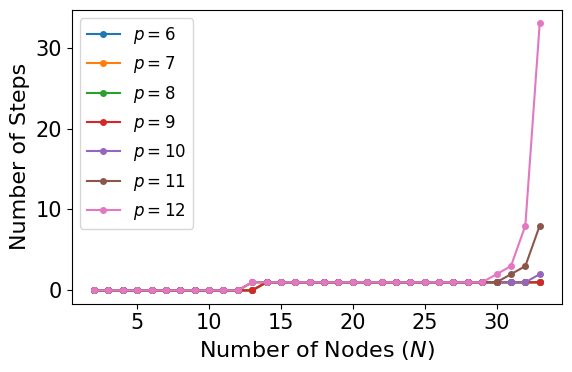

In [17]:
# Set font sizes for better readability
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15, 
    'font.size': 16,
    'legend.fontsize': 12
})

# Create figure showing steps vs number of nodes
plt.figure(figsize=(6, 4))
plt.xlabel('Number of Nodes ($N$)')
plt.ylabel('Number of Steps')

# Plot data for each physical dimension
for p in range(phys_min, phys_max):
    plt.plot(
        np.arange(n_nodes_min, n_nodes_max),
        stepss[:,p-phys_min,-1],
        'o-',
        label=f'$p={p}$',
        markersize=4
    )

plt.legend(loc='upper left', frameon=True)
plt.tight_layout()

# Save and display
plt.savefig('Steps_VS_Size_MPS_Frob.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Parameters for second MPS test
n_nodes_max2 = 26  # Maximum number of nodes
phys_max2 = 26     # Maximum physical dimension
bond_max2 = 11     # Maximum bond dimension

n_nodes_min2 = 25  # Minimum number of nodes 
phys_min2 = 2      # Minimum physical dimension
bond_min2 = 10     # Minimum bond dimension

# Run normalization test with new parameters
stepss2 = MPS_test(
    n_nodes_max=n_nodes_max2,
    phys_max=phys_max2, 
    bond_max=bond_max2,
    n_nodes_min=n_nodes_min2,
    phys_min=phys_min2,
    bond_min=bond_min2,
    method=method
)

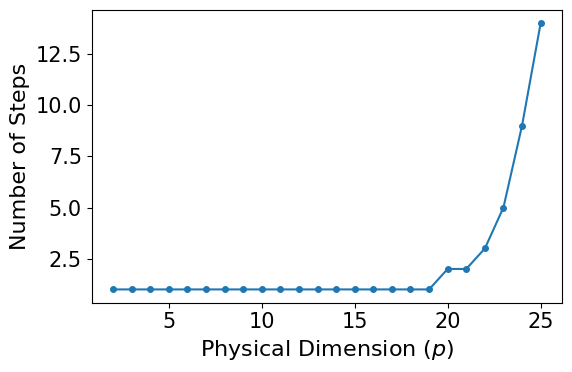

In [19]:
plt.figure('Steps vs Physical Dimension', figsize=(6, 4))
plt.xlabel('Physical Dimension ($p$)')
plt.ylabel('Number of Steps')

for i in range(n_nodes_min2, n_nodes_max2):
    plt.plot(
        np.arange(phys_min2, phys_max2),
        stepss2[i-n_nodes_min2,:,-1],
        'o-',
        label=f'$N={i}$',
        markersize=4
    )

plt.tight_layout()
plt.savefig('Steps_VS_Size_N_25_MPS_Frob.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Parameters for third MPS test
n_nodes_max3 = 26  # Maximum number of nodes
phys_max3 = 16     # Maximum physical dimension
bond_max3 = 51     # Maximum bond dimension

n_nodes_min3 = 25  # Minimum number of nodes
phys_min3 = 15     # Minimum physical dimension
bond_min3 = 20     # Minimum bond dimension

# Run normalization test with new parameters
stepss3 = MPS_test(
    n_nodes_max=n_nodes_max3,
    phys_max=phys_max3,
    bond_max=bond_max3, 
    n_nodes_min=n_nodes_min3,
    phys_min=phys_min3,
    bond_min=bond_min3,
    method=method
)

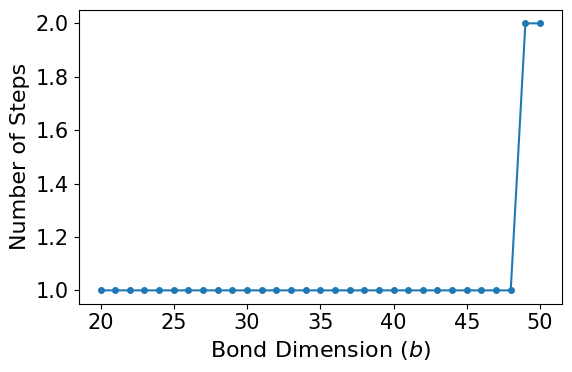

In [21]:
plt.figure('Steps vs Bond Dimension', figsize=(6, 4))
plt.xlabel('Bond Dimension ($b$)')
plt.ylabel('Number of Steps')
plt.plot(np.arange(bond_min3, bond_max3, dtype=int), stepss3[-1,-1,:], 'o-', markersize=4)

plt.tight_layout()
plt.savefig('Steps_VS_Bond_N_25_p_15_MPS_Frob.pdf', dpi=300, bbox_inches='tight')
plt.show()

### MPO

In [22]:
stepso = MPO_test(
    n_nodes_max=n_nodes_max,
    phys_max=phys_max, 
    bond_max=bond_max,
    n_nodes_min=n_nodes_min,
    phys_min=phys_min,
    bond_min=bond_min,
    method=method
)

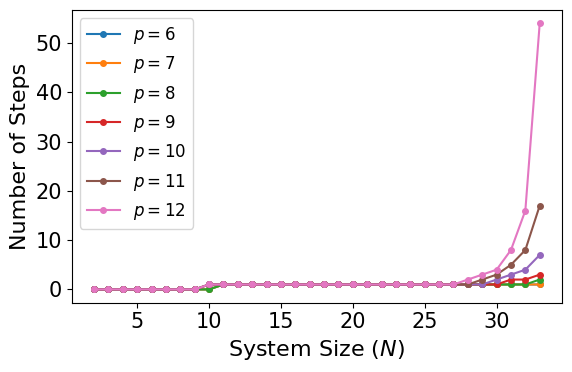

In [23]:
plt.figure('Steps vs System Size', figsize=(6, 4))
plt.xlabel('System Size ($N$)')
plt.ylabel('Number of Steps')

for i in range(phys_min, phys_max):
    plt.plot(np.arange(n_nodes_min, n_nodes_max), 
             stepso[:,i-phys_min,-1], 
             'o-', 
             markersize=4,
             label=f'$p={i}$')

plt.legend(loc='upper left', frameon=True)
plt.tight_layout()
plt.savefig('Steps_VS_Size_MPO_Frob.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
stepso2 = MPO_test(
    n_nodes_max=n_nodes_max2,
    phys_max=phys_max2,
    bond_max=bond_max2,
    n_nodes_min=n_nodes_min2,
    phys_min=phys_min2,
    bond_min=bond_min2,
    method=method
)

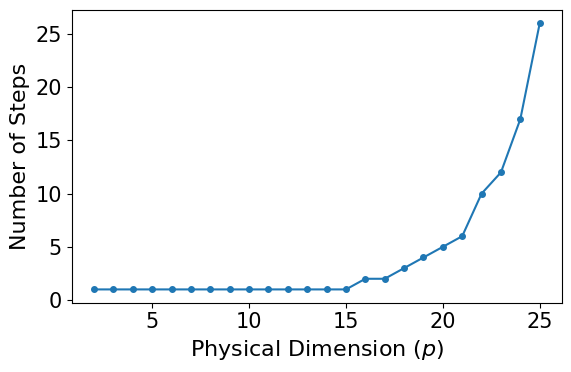

In [25]:
plt.figure('Steps vs Physical Dimension', figsize=(6, 4))
plt.xlabel('Physical Dimension ($p$)')
plt.ylabel('Number of Steps')

for i in range(n_nodes_min2, n_nodes_max2):
    plt.plot(
        np.arange(phys_min2, phys_max2),
        stepso2[i-n_nodes_min2,:,-1],
        'o-',
        label=f'$N={i}$',
        markersize=4
    )

plt.tight_layout()
plt.savefig('Steps_VS_Size_N_25_MPO_Frob.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
stepso3 = MPO_test(
    n_nodes_max=n_nodes_max3,
    phys_max=phys_max3,
    bond_max=bond_max3,
    n_nodes_min=n_nodes_min3,
    phys_min=phys_min3,
    bond_min=bond_min3,
    method=method
)

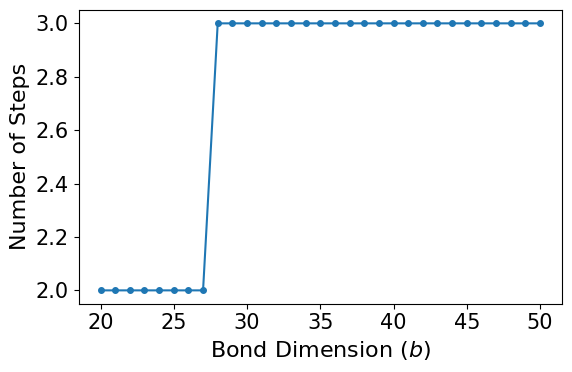

In [27]:
plt.figure('Steps vs Bond Dimension', figsize=(6, 4))
plt.xlabel('Bond Dimension ($b$)')
plt.ylabel('Number of Steps')
plt.plot(np.arange(bond_min3, bond_max3), stepso3[-1,-1,:], 'o-', markersize=4)

plt.tight_layout()
plt.savefig('Steps_VS_Size_N_20_p_20_MPO_Frob.pdf', dpi=300, bbox_inches='tight')
plt.show()

### All

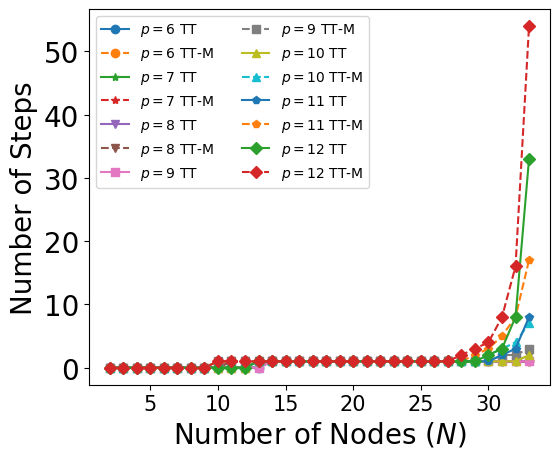

In [28]:
# Update font sizes for better readability
plt.rcParams.update({'xtick.labelsize': 15, 
                    'ytick.labelsize': 20, 
                    'font.size': 20})

# Create figure comparing steps vs N for different physical dimensions
plt.figure('Steps vs N', figsize=(6, 5))
plt.xlabel('Number of Nodes ($N$)')
plt.ylabel('Number of Steps')

# Define plot markers
symbols = ['o', '*', 'v', 's', '^', 'p', 'D']

# Plot data for each physical dimension
for i in range(phys_min, phys_max):
    # Plot TT data with solid lines
    plt.plot(np.arange(n_nodes_min, n_nodes_max), 
             stepss[:,i-phys_min,-1], 
             symbols[i-phys_min]+'-',
             label=f'$p={i}$ TT',
             markersize=6)
    
    # Plot TT-M data with dashed lines
    plt.plot(np.arange(n_nodes_min, n_nodes_max),
             stepso[:,i-phys_min,-1],
             symbols[i-phys_min]+'--', 
             label=f'$p={i}$ TT-M',
             markersize=6)

# Customize legend and layout
plt.legend(loc='upper left', fontsize=10, ncol=2)
plt.tight_layout()

# Save and display figure
plt.savefig('Steps_VS_Size_Frob.pdf', dpi=300, bbox_inches='tight')
plt.show()

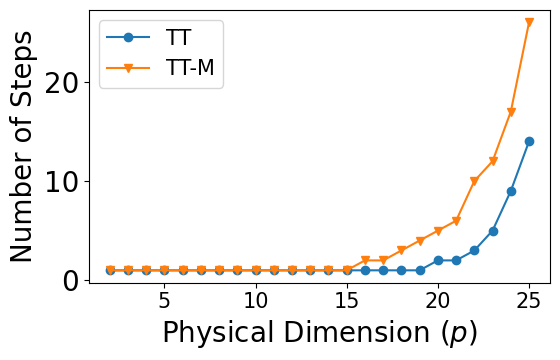

In [29]:
# Create figure comparing steps vs physical dimension
plt.figure('Steps vs Physical Dimension', figsize=(6, 4))
plt.xlabel('Physical Dimension ($p$)')
plt.ylabel('Number of Steps')

# Plot data for each number of nodes
for i in range(n_nodes_min2, n_nodes_max2):
    # Plot TT data with solid line
    plt.plot(np.arange(phys_min2, phys_max2, dtype=int),
             stepss2[i-n_nodes_min2,:,-1],
             'o-',
             label='TT')
    
    # Plot TT-M data with dashed line
    plt.plot(np.arange(phys_min2, phys_max2, dtype=int),
             stepso2[i-n_nodes_min2,:,-1],
             'v-', 
             label='TT-M')

# Customize legend and layout
plt.legend(loc='upper left', fontsize=15)
plt.tight_layout()

# Save and display figure
plt.savefig('Steps_VS_Size_N_25_Frob.pdf')
plt.show()

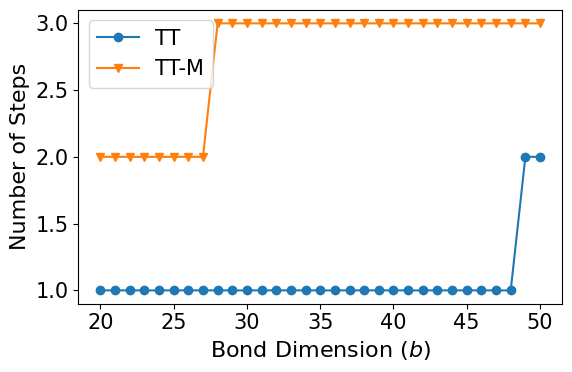

In [30]:
# Update font sizes for better readability
plt.rcParams.update({'xtick.labelsize': 15,
                    'ytick.labelsize': 15,
                    'font.size': 16})

# Create figure comparing steps vs bond dimension
plt.figure('Steps vs Bond Dimension', figsize=(6, 4))
plt.xlabel('Bond Dimension ($b$)')
plt.ylabel('Number of Steps')


# Plot data for TT and TT-M
plt.plot(np.arange(bond_min3, bond_max3, dtype=int), 
         stepss3[-1,-1,:], 
         'o-', 
         label='TT',
         markersize=6)
plt.plot(np.arange(bond_min3, bond_max3, dtype=int),
         stepso3[-1,-1,:], 
         'v-', 
         label='TT-M',
         markersize=6)

# Customize legend and layout
plt.legend(loc='upper left', fontsize=15)
plt.tight_layout()

# Save and display figure
plt.savefig('Steps_VS_Size_N_20_p_3_Frob.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Lineal

### MPS

In [31]:
# Define test parameters
'''n_nodes_max = 105  # Maximum number of nodes
phys_max = 15     # Maximum physical dimension
bond_max = 31     # Maximum bond dimension

n_nodes_min = 100 # Minimum number of nodes  
phys_min = 10    # Minimum physical dimension
bond_min = 30    # Minimum bond dimension
'''
# Method for normalization
method = 'Lineal'

# Run MPS test with specified parameters
stepss = MPS_test(
    n_nodes_max=n_nodes_max,
    phys_max=phys_max,
    bond_max=bond_max, 
    n_nodes_min=n_nodes_min,
    phys_min=phys_min,
    bond_min=bond_min,
    method=method
)

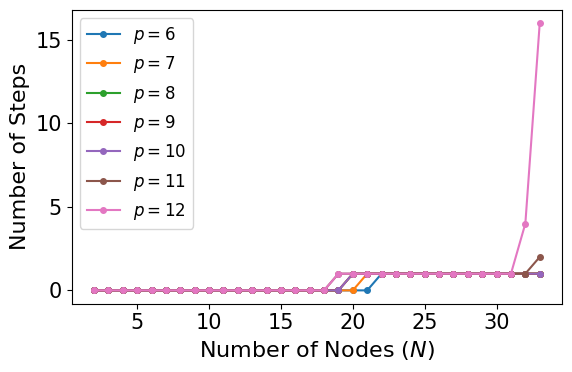

In [32]:
# Set font sizes for better readability
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15, 
    'font.size': 16,
    'legend.fontsize': 12
})

# Create figure showing steps vs number of nodes
plt.figure(figsize=(6, 4))
plt.xlabel('Number of Nodes ($N$)')
plt.ylabel('Number of Steps')

# Plot data for each physical dimension
for p in range(phys_min, phys_max):
    plt.plot(
        np.arange(n_nodes_min, n_nodes_max),
        stepss[:,p-phys_min,-1],
        'o-',
        label=f'$p={p}$',
        markersize=4
    )

plt.legend(loc='upper left', frameon=True)
plt.tight_layout()

# Save and display
plt.savefig('Steps_VS_Size_MPS_Lineal.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
# Parameters for second MPS test
'''n_nodes_max2 = 26  # Maximum number of nodes
phys_max2 = 26     # Maximum physical dimension
bond_max2 = 11     # Maximum bond dimension

n_nodes_min2 = 25  # Minimum number of nodes 
phys_min2 = 2      # Minimum physical dimension
bond_min2 = 10     # Minimum bond dimension
'''
# Run normalization test with new parameters
stepss2 = MPS_test(
    n_nodes_max=n_nodes_max2,
    phys_max=phys_max2, 
    bond_max=bond_max2,
    n_nodes_min=n_nodes_min2,
    phys_min=phys_min2,
    bond_min=bond_min2,
    method=method
)

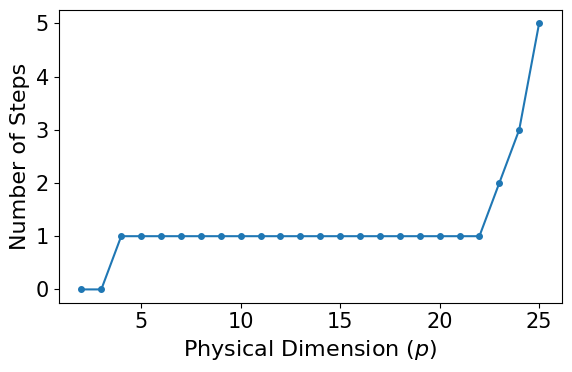

In [34]:
plt.figure('Steps vs Physical Dimension', figsize=(6, 4))
plt.xlabel('Physical Dimension ($p$)')
plt.ylabel('Number of Steps')

for i in range(n_nodes_min2, n_nodes_max2):
    plt.plot(
        np.arange(phys_min2, phys_max2),
        stepss2[i-n_nodes_min2,:,-1],
        'o-',
        label=f'$N={i}$',
        markersize=4
    )

plt.tight_layout()
plt.savefig('Steps_VS_Size_N_25_MPS_Lineal.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
# Parameters for third MPS test
'''n_nodes_max3 = 26  # Maximum number of nodes
phys_max3 = 16     # Maximum physical dimension
bond_max3 = 51     # Maximum bond dimension

n_nodes_min3 = 25  # Minimum number of nodes
phys_min3 = 15     # Minimum physical dimension
bond_min3 = 20     # Minimum bond dimension
'''
# Run normalization test with new parameters
stepss3 = MPS_test(
    n_nodes_max=n_nodes_max3,
    phys_max=phys_max3,
    bond_max=bond_max3, 
    n_nodes_min=n_nodes_min3,
    phys_min=phys_min3,
    bond_min=bond_min3,
    method=method
)

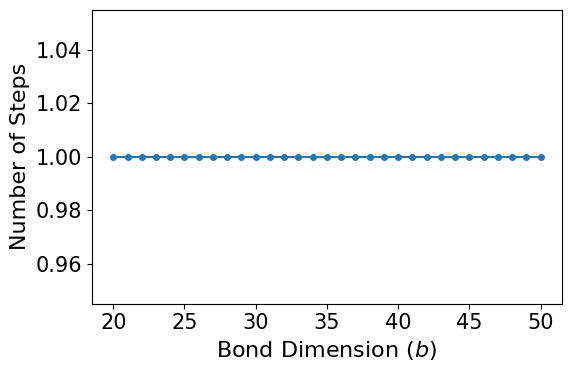

In [36]:
plt.figure('Steps vs Bond Dimension', figsize=(6, 4))
plt.xlabel('Bond Dimension ($b$)')
plt.ylabel('Number of Steps')
plt.plot(np.arange(bond_min3, bond_max3, dtype=int), stepss3[-1,-1,:], 'o-', markersize=4)

plt.tight_layout()
plt.savefig('Steps_VS_Bond_N_25_p_15_MPS_Lineal.pdf', dpi=300, bbox_inches='tight')
plt.show()

### MPO

In [37]:
stepso = MPO_test(
    n_nodes_max=n_nodes_max,
    phys_max=phys_max, 
    bond_max=bond_max,
    n_nodes_min=n_nodes_min,
    phys_min=phys_min,
    bond_min=bond_min,
    method=method
)

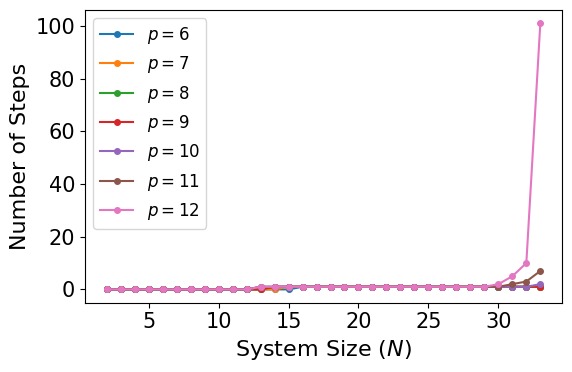

In [38]:
plt.figure('Steps vs System Size', figsize=(6, 4))
plt.xlabel('System Size ($N$)')
plt.ylabel('Number of Steps')

for i in range(phys_min, phys_max):
    plt.plot(np.arange(n_nodes_min, n_nodes_max), 
             stepso[:,i-phys_min,-1], 
             'o-', 
             markersize=4,
             label=f'$p={i}$')

plt.legend(loc='upper left', frameon=True)
plt.tight_layout()
plt.savefig('Steps_VS_Size_MPO_Lineal.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
stepso2 = MPO_test(
    n_nodes_max=n_nodes_max2,
    phys_max=phys_max2,
    bond_max=bond_max2,
    n_nodes_min=n_nodes_min2,
    phys_min=phys_min2,
    bond_min=bond_min2,
    method=method
)

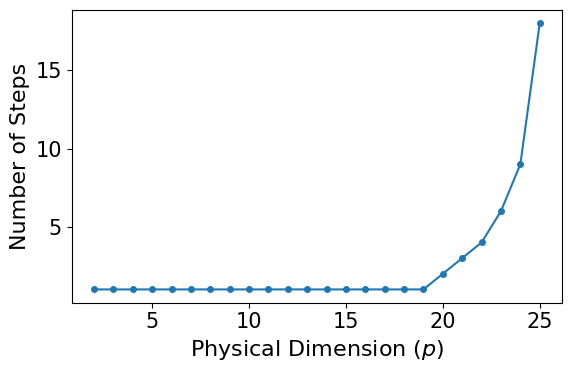

In [40]:
plt.figure('Steps vs Physical Dimension', figsize=(6, 4))
plt.xlabel('Physical Dimension ($p$)')
plt.ylabel('Number of Steps')

for i in range(n_nodes_min2, n_nodes_max2):
    plt.plot(
        np.arange(phys_min2, phys_max2),
        stepso2[i-n_nodes_min2,:,-1],
        'o-',
        label=f'$N={i}$',
        markersize=4
    )

plt.tight_layout()
plt.savefig('Steps_VS_Size_N_25_MPO_Lineal.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
stepso3 = MPO_test(
    n_nodes_max=n_nodes_max3,
    phys_max=phys_max3,
    bond_max=bond_max3,
    n_nodes_min=n_nodes_min3,
    phys_min=phys_min3,
    bond_min=bond_min3,
    method=method
)

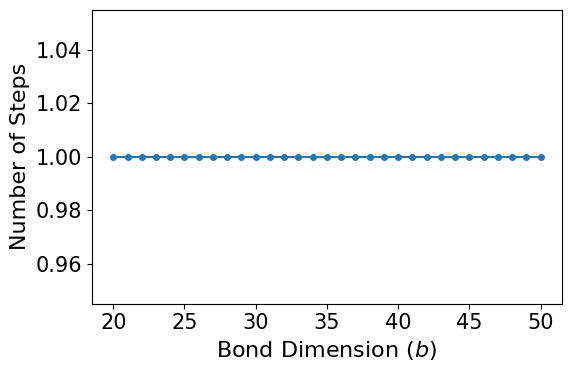

In [42]:
plt.figure('Steps vs Bond Dimension', figsize=(6, 4))
plt.xlabel('Bond Dimension ($b$)')
plt.ylabel('Number of Steps')
plt.plot(np.arange(bond_min3, bond_max3), stepso3[-1,-1,:], 'o-', markersize=4)

plt.tight_layout()
plt.savefig('Steps_VS_Size_N_20_p_20_MPO_Lineal.pdf', dpi=300, bbox_inches='tight')
plt.show()

### All

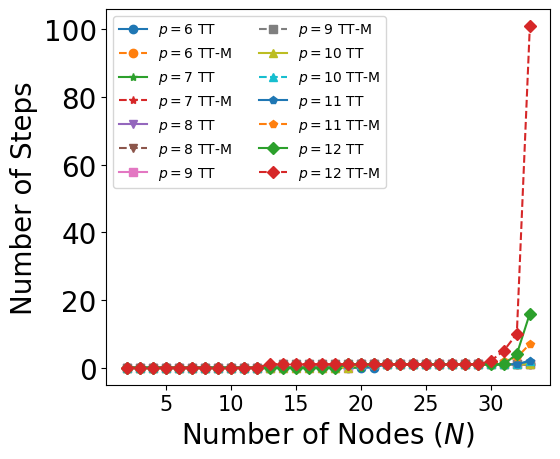

In [43]:
# Update font sizes for better readability
plt.rcParams.update({'xtick.labelsize': 15, 
                    'ytick.labelsize': 20, 
                    'font.size': 20})

# Create figure comparing steps vs N for different physical dimensions
plt.figure('Steps vs N', figsize=(6, 5))
plt.xlabel('Number of Nodes ($N$)')
plt.ylabel('Number of Steps')

# Define plot markers
symbols = ['o', '*', 'v', 's', '^', 'p', 'D']

# Plot data for each physical dimension
for i in range(phys_min, phys_max):
    # Plot TT data with solid lines
    plt.plot(np.arange(n_nodes_min, n_nodes_max), 
             stepss[:,i-phys_min,-1], 
             symbols[i-phys_min]+'-',
             label=f'$p={i}$ TT',
             markersize=6)
    
    # Plot TT-M data with dashed lines
    plt.plot(np.arange(n_nodes_min, n_nodes_max),
             stepso[:,i-phys_min,-1],
             symbols[i-phys_min]+'--', 
             label=f'$p={i}$ TT-M',
             markersize=6)

# Customize legend and layout
plt.legend(loc='upper left', fontsize=10, ncol=2)
plt.tight_layout()

# Save and display figure
plt.savefig('Steps_VS_Size_Lineal.pdf', dpi=300, bbox_inches='tight')
plt.show()

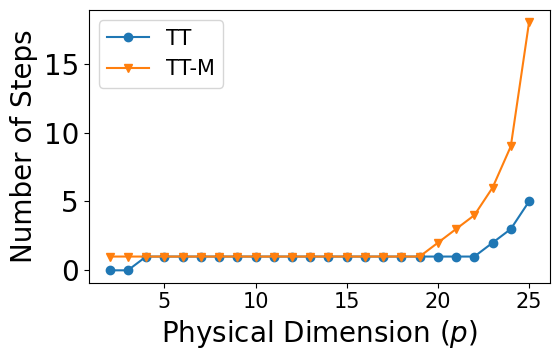

In [44]:
# Create figure comparing steps vs physical dimension
plt.figure('Steps vs Physical Dimension', figsize=(6, 4))
plt.xlabel('Physical Dimension ($p$)')
plt.ylabel('Number of Steps')

# Plot data for each number of nodes
for i in range(n_nodes_min2, n_nodes_max2):
    # Plot TT data with solid line
    plt.plot(np.arange(phys_min2, phys_max2, dtype=int),
             stepss2[i-n_nodes_min2,:,-1],
             'o-',
             label='TT')
    
    # Plot TT-M data with dashed line
    plt.plot(np.arange(phys_min2, phys_max2, dtype=int),
             stepso2[i-n_nodes_min2,:,-1],
             'v-', 
             label='TT-M')

# Customize legend and layout
plt.legend(loc='upper left', fontsize=15)
plt.tight_layout()

# Save and display figure
plt.savefig('Steps_VS_Size_N_25_Lineal.pdf')
plt.show()

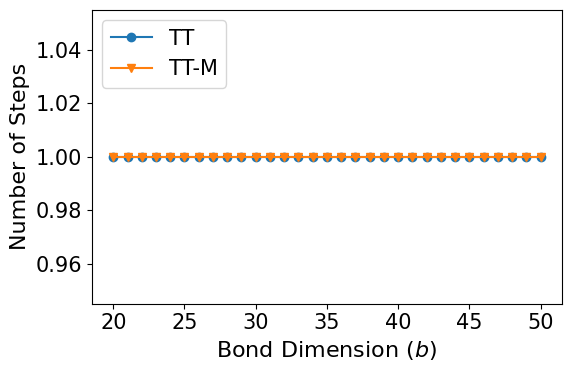

In [45]:
# Update font sizes for better readability
plt.rcParams.update({'xtick.labelsize': 15,
                    'ytick.labelsize': 15,
                    'font.size': 16})

# Create figure comparing steps vs bond dimension
plt.figure('Steps vs Bond Dimension', figsize=(6, 4))
plt.xlabel('Bond Dimension ($b$)')
plt.ylabel('Number of Steps')


# Plot data for TT and TT-M
plt.plot(np.arange(bond_min3, bond_max3, dtype=int), 
         stepss3[-1,-1,:], 
         'o-', 
         label='TT',
         markersize=6)
plt.plot(np.arange(bond_min3, bond_max3, dtype=int),
         stepso3[-1,-1,:], 
         'v-', 
         label='TT-M',
         markersize=6)

# Customize legend and layout
plt.legend(loc='upper left', fontsize=15)
plt.tight_layout()

# Save and display figure
plt.savefig('Steps_VS_Size_N_20_p_3_Lineal.pdf', dpi=300, bbox_inches='tight')
plt.show()